In [2]:
import pandas as pd
from datetime import datetime as dt
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os

In [3]:
print(f'Current working directory is {os.getcwd()}')

Current working directory is C:\Users\cavin\Documents\NSS_Projects\ACCR-project-clj\accre-carbonara\notebooks


In [4]:
pd.options.mode.copy_on_write = True
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [5]:
df = pd.read_csv("../data/clean_df.csv", low_memory=False)

In [6]:
ce56 = pd.read_csv("../data/ce56.csv")

In [7]:
# df = pd.read_csv('../data/ready_df.csv')

In [8]:
ce56['END'] = pd.to_datetime(ce56['END']).dt.floor('min')

In [9]:
df['END'] = pd.to_datetime(df['END']).dt.floor('D')
df['BEGIN'] = pd.to_datetime(df['BEGIN'])

In [10]:
df['date'] = df['END'].dt.date

In [11]:
df_count = df.groupby('END')['FAILED'].value_counts().reset_index()

In [12]:
count_1 = df_count[df_count['FAILED'] == 1]

In [13]:
count_0 = df_count[df_count['FAILED'] == 0]

In [14]:
counts = pd.concat([count_0, count_1])

In [15]:
value_counts = counts['END'].value_counts()

In [108]:
value_counts

END
2021-04-05    2
2021-04-28    2
2021-03-22    2
2021-03-23    2
2021-03-24    2
             ..
2021-03-25    1
2021-04-03    1
2021-04-04    1
2020-10-02    1
2021-10-07    1
Name: count, Length: 372, dtype: int64

In [16]:
counts = counts[counts['END'].isin(value_counts.index)]

In [17]:
df = df.sort_values('END')

df['rolling_end'] = (
    df
    .rolling('30d', on = 'END')['JOBID']
    .count()
)

df['rolling_average'] = df['rolling_end'] / 30

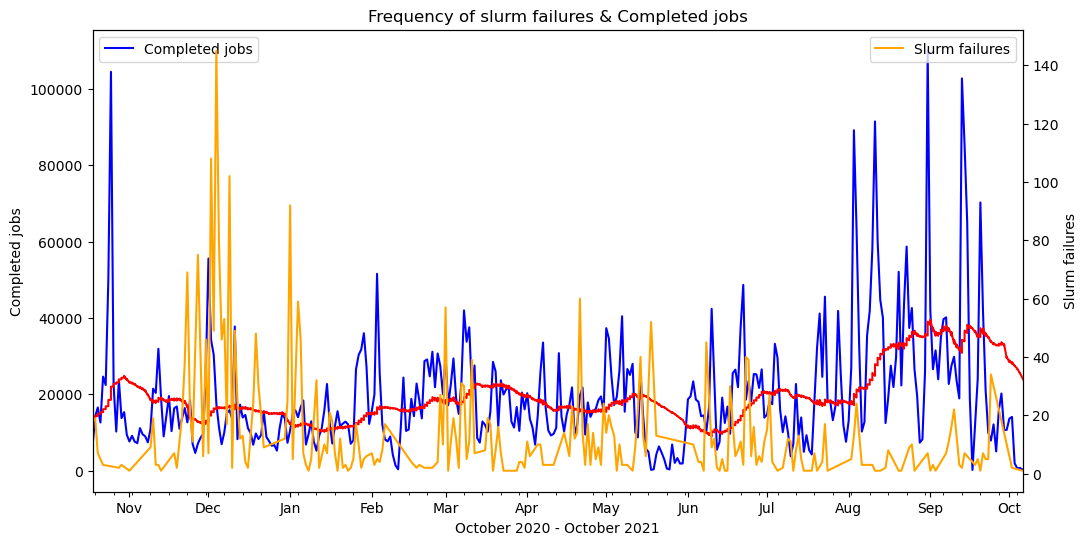

In [82]:
fig, ax1 = plt.subplots(figsize = (12,6))
(
    counts[counts['FAILED'] == 0]
    .plot(x = 'END', 
          y = 'count', 
          ax = ax1, 
          label ='Completed jobs',
          color='blue')
)
(
        df
    .set_index('END')['rolling_average']
    .plot(label = '30 day rolling average',
          color = 'red')
)
ax2 = ax1.twinx()
(
    counts[counts['FAILED'] == 1]
    .plot(x = 'END', 
          y = 'count', 
          ax = ax2, 
          label ='Slurm failures',
          color='orange')
)
ax1.set_ylabel('Completed jobs')
ax2.set_ylabel('Slurm failures')
ax1.set_xlabel('October 2020 - October 2021')
ax2.set_xlabel('30 day rolling average')
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.title('Frequency of slurm failures & Completed jobs')
# plt.savefig('../images/slurm_complete.png', dpi = 150)
plt.show();

In [19]:
diffmem = df[df['DIFFMEM'] <= 0]

In [21]:
df['USEDMEM'].describe()

count   6296152.00
mean       3101.91
std        9502.53
min           0.00
25%         195.00
50%         586.05
75%        2484.41
max      992579.85
Name: USEDMEM, dtype: float64

In [22]:
df['REQMEM'].describe()

count   7395234.00
mean      12389.99
std       26073.85
min           1.00
25%        2048.00
50%        4096.00
75%       14000.00
max     1026375.00
Name: REQMEM, dtype: float64

In [102]:
df[['DIFFMEM', 'USEDMEM']].corr()

,DIFFMEM,USEDMEM
DIFFMEM,1.00,0.18
USEDMEM,0.18,1.00


In [84]:
log = smf.logit("FAILED ~ END", data = df_count).fit()

         Current function value: 0.536704
         Iterations: 35


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [86]:
log.params

Intercept                                 -18.95
END[T.Timestamp('2020-10-02 00:00:00')]    -4.86
END[T.Timestamp('2020-10-03 00:00:00')]    -4.86
END[T.Timestamp('2020-10-04 00:00:00')]    -4.86
END[T.Timestamp('2020-10-05 00:00:00')]    -4.86
                                           ...  
END[T.Timestamp('2021-10-03 00:00:00')]    -4.86
END[T.Timestamp('2021-10-04 00:00:00')]    -4.86
END[T.Timestamp('2021-10-05 00:00:00')]    -4.86
END[T.Timestamp('2021-10-06 00:00:00')]    18.95
END[T.Timestamp('2021-10-07 00:00:00')]    -4.86
Length: 372, dtype: float64

In [88]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [94]:
logit_p = log.params['Intercept'] + log.params["END[T.Timestamp('2020-10-02 00:00:00')]"]